## Coursera - IBM Data Science Capstone Project ##

### Brian Lee ###
BrianTrewLee@gmail.com



LinkedIn: https://www.linkedin.com/in/brian-lee-64a2022b/

## 1. Introduction ##

Where in the world can you find a StarBuck's? Well... everywhere... almost. Is there a science to locating a StarBuck's? Can we create a model to predict where a StarBuck's is likely to be located?

In [1]:
# import libraries

import urllib.request # open and read URLs

import json # handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # handle requests
import pandas as pd # process data as dataframes with Pandas
import numpy as np # handle data in a vectorized manner with NumPy

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed the GeoPy geocoding library yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed the Folium library yet
import folium # map rendering library

# Matplolib plotting library and associated modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans # for K-Means clustering with Scikit-Learn

print("Libraries imported!")

Libraries imported!


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# Define a function to gather recommended venues, with specifically the name and category, using the explore API

def getNearbyVenues(latitudes, longitudes, radius=300, limit=100):
#def getNearbyVenues(latitudes, longitudes, radius=300, limit=100):
#def getNearbyVenues(latitudes, longitudes, radius=750, limit=100):
#def getNearbyVenues(latitudes, longitudes, radius=2000, limit=100):
    
    count = 0
    venues_list = []
    for lat, lng in zip(latitudes, longitudes):
        print(lat,'-',lng)
         
        #create a unique namefor this pointthat is easier todeal with than a combination of lat and lon
        point_name = "point"+str(count)
            
        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        #print("resultscols=",results.columns)
        

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            point_name,
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["location"]["distance"], 
            v["venue"]["categories"][0]["name"]) for v in results])
        count = count + 1
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["Point Name",
                  "Neighborhood Latitude", 
                  "Neighborhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Distance",           
                  "Venue Category"]
    
    return(nearby_venues)

In [4]:
sf_lat=37.7749
sf_lon=-122.4194
ch_lat=41.8781
ch_lon=-87.6298
la_lat=34.0522
la_lon=-118.2437
starbucks_m_lat=37.744644
starbucks_m_lon=-122.452731
import random

#37.780253, -122.509117
#37.804203, -122.459264 - upper left of starbucks intensive space
#37.767547, -122.409342 - lower right ofstarbucksintensive space
llat=37.767547
ulat=37.804203
llon=-122.459264
ulon=-122.409342
random_lat0 = random.uniform(37.767547,37.804203)
random_lon0 = random.uniform(-122.459264, -122.409342)
random_lat1 = random.uniform(llat,ulat)
random_lon1 = random.uniform(llon, ulon)
random_lat2 = random.uniform(llat,ulat)
random_lon2 = random.uniform(llon, ulon)
random_lat3 = random.uniform(llat,ulat)
random_lon3 = random.uniform(llon, ulon)
random_lat4 = random.uniform(llat,ulat)
random_lon4 = random.uniform(llon, ulon)
random_lat5 = random.uniform(llat,ulat)
random_lon5 = random.uniform(llon, ulon)
random_lat6 = random.uniform(llat,ulat)
random_lon6 = random.uniform(llon, ulon)
random_lat7 = random.uniform(llat,ulat)
random_lon7 = random.uniform(llon, ulon)
random_lat8 = random.uniform(llat,ulat)
random_lon8 = random.uniform(llon, ulon)
random_lat9 = random.uniform(llat,ulat)
random_lon9 = random.uniform(llon, ulon)

data = pd.DataFrame(np.array([[sf_lat, sf_lon], [ch_lat, ch_lon], [la_lat, la_lon], [starbucks_m_lat,starbucks_m_lon], [random_lat0,random_lon0], [random_lat1,random_lon1], [random_lat2,random_lon2], [random_lat3,random_lon3], [random_lat4,random_lon4], [random_lat5,random_lon5], [random_lat6,random_lon6], [random_lat7,random_lon7], [random_lat8,random_lon8], [random_lat9,random_lon9] ]), columns=['Latitude', 'Longitude'])

data



,Latitude,Longitude
0,37.774900,-122.419400
1,41.878100,-87.629800
2,34.052200,-118.243700
3,37.744644,-122.452731
4,37.774607,-122.428936
5,37.795721,-122.447484
6,37.792434,-122.430767
7,37.801062,-122.424319
8,37.793637,-122.409410
9,37.799006,-122.421157


In [18]:
random_latlons = []
for j in range(0,100):
    random_lat = random.uniform(llat,ulat)
    random_lon = random.uniform(llon,ulon)
    random_latlon=(random_lat,random_lon)
    random_latlons.append(random_latlon)
    

In [42]:
random_latlons = pd.DataFrame(random_latlons)
random_lats=random_latlons[0]
random_lons=random_latlons[1]
random_lats.shape



(100,)

In [37]:
random_latlons[0].shape

(100,)

In [38]:
random_latlons[1].shape

(100,)

In [36]:


data["Latitude"] = random_latlons[0]
data["Longitude"] = random_latlons[1]

data["Latitude"].head()
data["Latitude"].shape


(14,)

In [34]:
data["Longitude"].head()
data.shape

(14, 2)

In [43]:

#venues = getNearbyVenues(latitudes = data["Latitude"],
#                               longitudes = data["Longitude"]
#                               )
venues = getNearbyVenues(latitudes = random_lats,
                               longitudes = random_lons
                               )


37.79165004394366 - -122.45550086572106
37.793168849005134 - -122.41670324720802
37.77134229706252 - -122.45675001115005
37.78195675974728 - -122.43442033365785
37.78273802755426 - -122.41232590016035
37.776422984627494 - -122.44377797497735
37.772100155400324 - -122.43994097709069
37.78483767033057 - -122.4490565802201
37.802118477261956 - -122.41740879762008
37.77955158477152 - -122.44212769511655
37.794444755463815 - -122.45451369648639
37.78208297625733 - -122.44208705203731
37.79660385185312 - -122.43432699521647
37.78776785923844 - -122.45164642376496
37.77489420972858 - -122.41721646919265
37.79969855381702 - -122.45460001280982
37.77164883489783 - -122.43412334175076
37.793339234065044 - -122.44568562186512
37.788877229319475 - -122.44820325501767
37.79778227326554 - -122.40982069123643
37.770887084368496 - -122.45047753921362
37.78885828680595 - -122.42405840625837
37.798419052854776 - -122.44227581832456
37.80238628332039 - -122.4587634267213
37.79997669125486 - -122.40957802

,Point Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,point0,37.791650,-122.455501,Julius Kahn Playground & Clubhouse,37.791163,-122.453511,183,Playground
1,point0,37.791650,-122.455501,Inspiration Point,37.792207,-122.458317,255,Scenic Lookout
2,point0,37.791650,-122.455501,El Polín Spring,37.793204,-122.455518,172,Park
3,point0,37.791650,-122.455501,Ecology Trail,37.793111,-122.458204,288,Trail
4,point0,37.791650,-122.455501,Julius Kahn Field,37.791097,-122.453334,200,Baseball Field
5,point0,37.791650,-122.455501,San Francisco Decorator Showcase,37.790029,-122.454965,186,Public Art
6,point0,37.791650,-122.455501,Julius Kahn Park,37.791005,-122.454069,144,Park
7,point0,37.791650,-122.455501,Inspiration Point Trail End Bunker,37.792337,-122.458348,261,Trail
8,point0,37.791650,-122.455501,Paul Goode Field,37.793678,-122.453674,277,Baseball Field
9,point1,37.793169,-122.416703,Hot Sauce and Panko,37.794576,-122.418080,198,Wings Joint


In [45]:
venues.tail()

,Point Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
2557,point99,37.798893,-122.440464,Ristorante Parma,37.800030,-122.437703,273,Italian Restaurant
2558,point99,37.798893,-122.440464,The Plant,37.800477,-122.437745,297,Salad Place
2559,point99,37.798893,-122.440464,Toma,37.800028,-122.437749,270,Burrito Place
2560,point99,37.798893,-122.440464,Mel's Drive-In,37.799669,-122.437237,296,Diner
2561,point99,37.798893,-122.440464,Saiwalks,37.800386,-122.437765,289,Vietnamese Restaurant


In [46]:
venues['Venue'].unique()
venues['Venue'].value_counts()

Starbucks                             12
Trader Joe's                          10
Peet's Coffee & Tea                    9
Chase Bank                             7
Tacolicious                            7
Project Juice                          7
Marine Layer                           6
Artesano                               5
Pluto's                                5
Books Inc.                             5
Magic Flute Ristorante                 5
Bonita Taqueria y Rotisserie           5
Marina Deli & Liquors                  5
El Polín Spring                        5
Wells Fargo                            5
Chubby Noodle                          5
Beautifull                             5
Iza Ramen                              5
Roma Antica                            5
Julius Kahn Playground & Clubhouse     5
Whole Foods Market                     5
Books Inc                              5
Liquid Gold                            5
Bryan's Market                         5
Souvla          

In [47]:
venues[350:400]


# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['point_name'] = venues['Point Name'] 
onehot['point_lat'] = venues['Neighborhood Latitude'] 
onehot['point_lon'] = venues['Neighborhood Longitude'] 
onehot['isStarbucks'] = (venues['Venue'] == "Starbucks")
# move neighborhood column to the first column
fixed_columns = [onehot.columns[-3]] + [onehot.columns[-2]] + [onehot.columns[-1]] + list(onehot.columns[:-3])
onehot = onehot[fixed_columns]

onehot.isStarbucks = onehot.isStarbucks.astype(int)

onehot.head()
onehot['isStarbucks'].value_counts()

0    2550
1      12
Name: isStarbucks, dtype: int64

In [48]:
venues.head()

,Point Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,point0,37.79165,-122.455501,Julius Kahn Playground & Clubhouse,37.791163,-122.453511,183,Playground
1,point0,37.79165,-122.455501,Inspiration Point,37.792207,-122.458317,255,Scenic Lookout
2,point0,37.79165,-122.455501,El Polín Spring,37.793204,-122.455518,172,Park
3,point0,37.79165,-122.455501,Ecology Trail,37.793111,-122.458204,288,Trail
4,point0,37.79165,-122.455501,Julius Kahn Field,37.791097,-122.453334,200,Baseball Field


In [49]:
grouped = onehot.groupby('point_name').mean().reset_index()
grouped

,point_name,point_lat,point_lon,isStarbucks,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,point0,37.791650,-122.455501,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,point1,37.793169,-122.416703,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.047619,0.000000,0.000000
2,point10,37.794445,-122.454514,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,point11,37.782083,-122.442087,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,point12,37.796604,-122.434327,0.000000,0.000000,0.000000,0.000,0.018868,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.056604,0.000000,0.0,0.000000,0.018868,0.000000
5,point13,37.787768,-122.451646,0.050000,0.000000,0.000000,0.000,0.100000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,point14,37.774894,-122.417216,0.000000,0.000000,0.000000,0.000,0.026316,0.0,0.000000,...,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,point15,37.799699,-122.454600,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.071429
8,point16,37.771649,-122.434123,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.021739
9,point17,37.793339,-122.445686,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [50]:
num_top_venues = 50

for point in grouped['point_name']:
    print("----"+point+"----")
    temp = grouped[grouped['point_name'] == point].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----point0----
                            venue  freq
0                  Baseball Field  0.22
1                           Trail  0.22
2                            Park  0.22
3                      Public Art  0.11
4                      Playground  0.11
5                  Scenic Lookout  0.11
6           Indonesian Restaurant  0.00
7                       Newsstand  0.00
8                          Office  0.00
9                    Noodle House  0.00
10                      Nightclub  0.00
11                   Neighborhood  0.00
12        New American Restaurant  0.00
13                   Optical Shop  0.00
14                Nature Preserve  0.00
15                     Nail Salon  0.00
16                    Music Venue  0.00
17                    Music Store  0.00
18                   Music School  0.00
19                         Museum  0.00
20                    Opera House  0.00
21  Paper / Office Supplies Store  0.00
22           Other Great Outdoors  0.00
23              Outdoor S

In [51]:
grouped.head()

,point_name,point_lat,point_lon,isStarbucks,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,point0,37.791650,-122.455501,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,point1,37.793169,-122.416703,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.047619,0.0,0.0,0.047619,0.000000,0.0
2,point10,37.794445,-122.454514,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,point11,37.782083,-122.442087,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,point12,37.796604,-122.434327,0.0,0.0,0.0,0.0,0.018868,0.0,0.0,...,0.0,0.0,0.0,0.0,0.056604,0.0,0.0,0.000000,0.018868,0.0


In [52]:
y = grouped['isStarbucks'] > 0
y = pd.DataFrame(y)
y = y.isStarbucks.astype(int)
print(y.value_counts())
X = grouped
print(X.shape)
X .drop(columns=['point_name', 'point_lat', 'point_lon', 'isStarbucks'], inplace=True)
print(X.columns)
print(X.shape)

0    88
1    10
Name: isStarbucks, dtype: int64
(98, 293)
Index(['Accessories Store', 'Adult Boutique', 'Afghan Restaurant',
       'American Restaurant', 'Amphitheater', 'Antique Shop', 'Arcade',
       'Arepa Restaurant', 'Argentinian Restaurant', 'Art Gallery',
       ...
       'Video Store', 'Vietnamese Restaurant', 'Warehouse Store', 'Whisky Bar',
       'Wine Bar', 'Wine Shop', 'Winery', 'Wings Joint', 'Women's Store',
       'Yoga Studio'],
      dtype='object', length=289)
(98, 289)


In [53]:
from sklearn.model_selection import train_test_split
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(78, 289) (78,)
(20, 289) (20,)


In [54]:
import sklearn as sk  
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)  
RF.fit(X, y)  
RF.predict(X)  
RF.score(X,y)

0.96938775510204078

In [56]:
estimator = RF.estimators_[5]

In [57]:
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1537364731, splitter='best')

In [61]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = 'has_starbucks',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

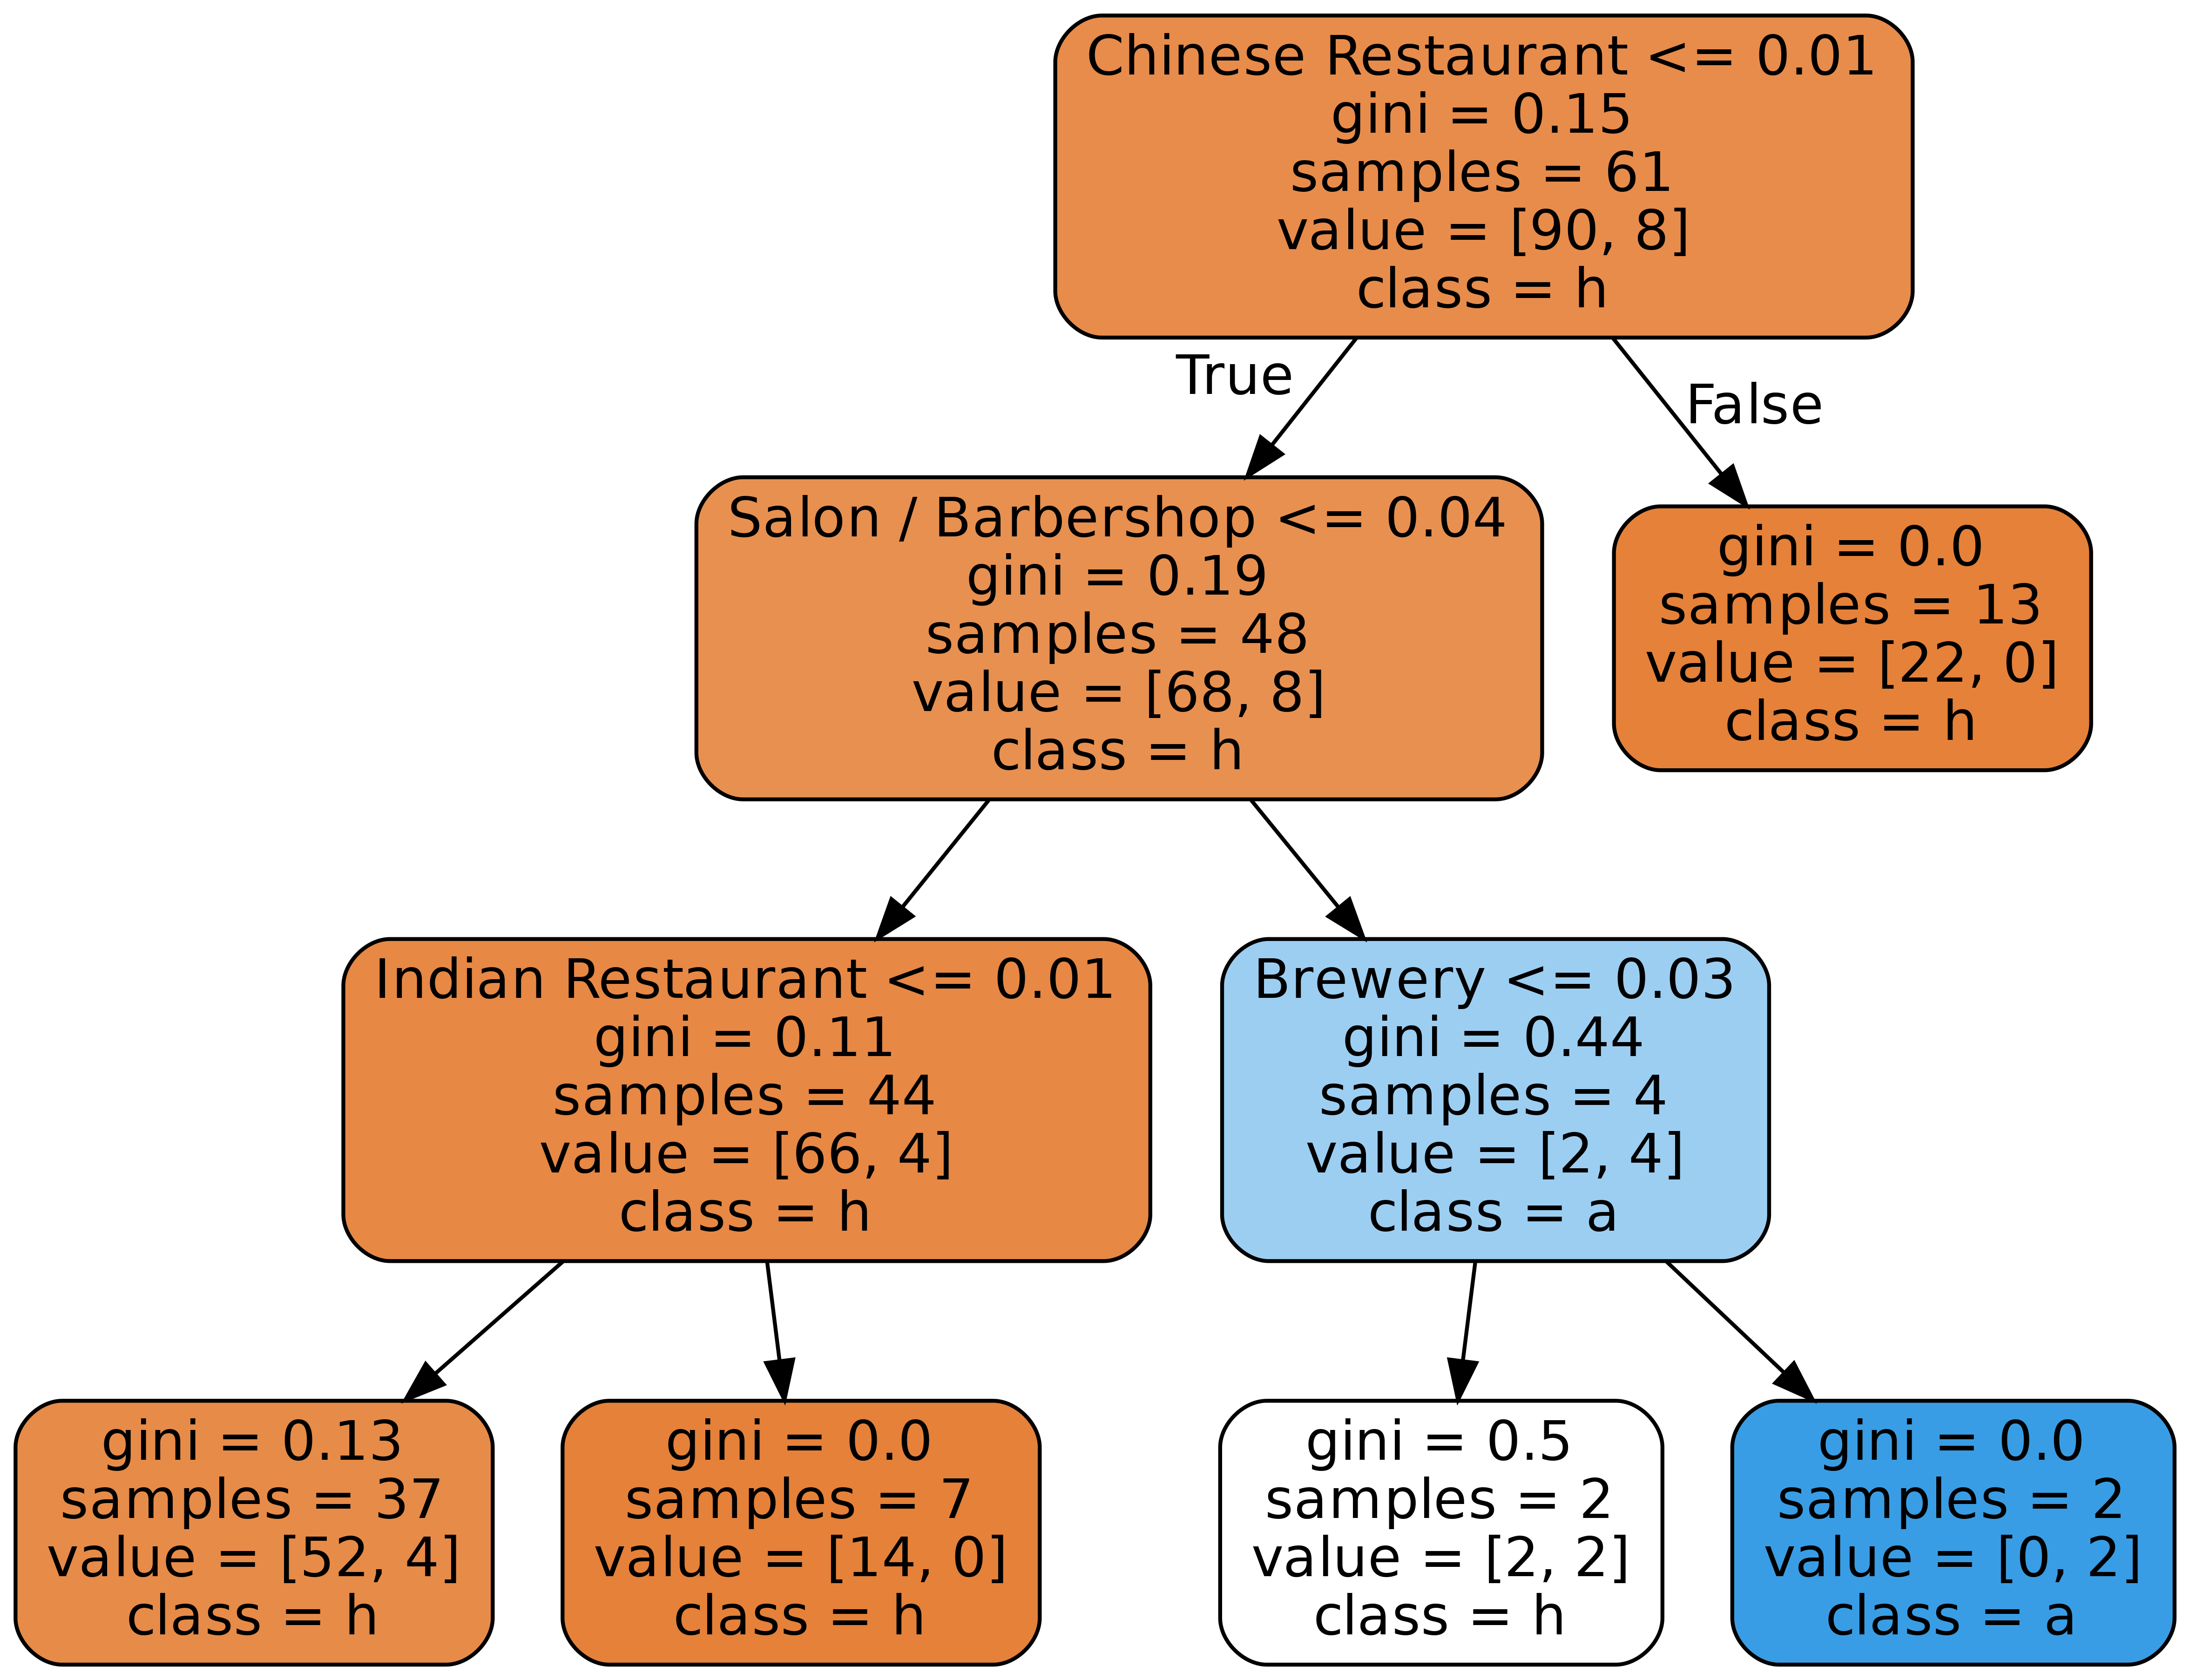

In [62]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')